# ITChromo -> Identificação de Cromossomos utilizando "Segment Anything" (Meta)

- Repositório Modelo -> https://github.com/facebookresearch/segment-anything<br/>

- Para instalação do modelo, utilizar: "pip install git+https://github.com/facebookresearch/segment-anything.git"

In [1]:
# Conjunto de Importações
import cv2
import random
from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patches as patches

In [2]:
'''
    Antes de utilizarmos o "Segment Anything" localmente, devemos baixar o seu modelo e seus datasets de treinamento.
    Para isso, baixaremos diretamente do KAGGLE, através da lib "kagglehub" e o "shutil" para movermos o arquivo para o diretório desejado
    Como podemos ver a seguir:
'''

import kagglehub            # -> lib do kaggle
import shutil
import os

# Nome do modelo e caminhos
model_name = "sam_vit_b_01ec64.pth"
model_dir = "./models/segment_anything"
final_model_path = os.path.join(model_dir, model_name)

# Se o modelo final já existe e tem tamanho plausível (>1MB), evita baixar de novo
if os.path.exists(final_model_path) and os.path.getsize(final_model_path) > 1_000_000:
    print(f"✅ Modelo já existe em: {final_model_path}")
else:
    print("⬇️  Tentando baixar modelo vit_b do Segment Anything...")

    # FORÇA o re-download limpando o cache se necessário
    kagglehub_cache = os.path.expanduser("~/.cache/kagglehub")
    if os.path.exists(kagglehub_cache):
        print("🧹 Limpando cache do kagglehub...")
        shutil.rmtree(kagglehub_cache)

    # Tenta baixar novamente
    try:
        model_path = kagglehub.model_download('metaresearch/segment-anything/PyTorch/vit-b/1')
    except Exception as e:
        print(f"❌ Erro ao baixar o modelo: {e}")
        exit(1)

    # Cria diretório final, se necessário
    os.makedirs(model_dir, exist_ok=True)

    # Move e renomeia o arquivo baixado
    moved = False
    for file_name in os.listdir(model_path):
        if file_name.endswith(".pth"):
            src = os.path.join(model_path, file_name)
            dst = os.path.join(model_dir, model_name)
            shutil.copy(src, dst)
            print(f"✅ Modelo salvo como: {dst}")
            moved = True

    if not moved:
        print("❌ Nenhum arquivo .pth encontrado após o download.")


✅ Modelo já existe em: ./models/segment_anything\sam_vit_b_01ec64.pth


In [3]:
# Função Auxiliar para plottagem e visualização das máscaras de cada cromossomo
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0],m.shape[1],3))
        color_mask = np.random.random((1,3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.8)))

In [4]:
# sam_checkpoint = '/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth'

sam_checkpoint = os.path.join("./models/segment_anything", "sam_vit_b_01ec64.pth")         # CASO SEJA PRECISO, MUDE O NOME DO ARQUIVO DO MODELO

model_type = "vit_b"            # tipo do modelo -> vision transformer BASE | Poderia ser usado os [vit-l | vit-h]
device = "cpu"                  # cpu ou cuda

# Inicializa o modelo com o checkpoint correto
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Criação do gerador de máscaras
mask_generator1 = SamAutomaticMaskGenerator(sam)

# GERAÇÃO AUTOMÁTICA DE MÁSCARA

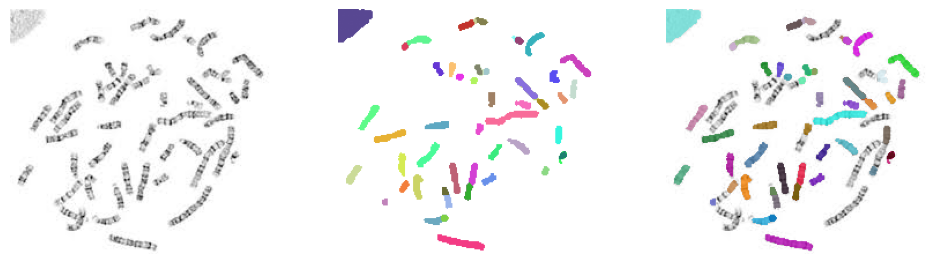

In [5]:
# path0='/kaggle/input/chromosome-image-dataset-karyotype/Data/24_chromosomes_object/JEPG/103064.jpg'
path0='..\datasets\ITChromo\ITChromo-Leo.png'                                    # TESTE INICIAL COM IMAGEM (qualidade ruim)
image = cv2.imread(path0)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.resize(image0,dsize=None,fx=0.1,fy=0.1)

masks1 = mask_generator1.generate(image)

fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(image)
axs[2].imshow(image) 
show_anns(masks1,axs[1])
show_anns(masks1,axs[2])
axs[0].axis('off')
axs[1].axis('off')    
axs[2].axis('off')    
plt.show()

In [6]:
# Criação de uma máscara totalmente branca, que será usada como FUNDO NEUTRO para criação de novas máscaras
bgw=np.ones(image.shape)*255
print(len(masks1))                      # quantas máscaras foram detectadas (cada máscara é um dicionário)
print(masks1[0].keys())                 # acessa o dicionário da primeira máscara

51
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


(212, 237, 3)


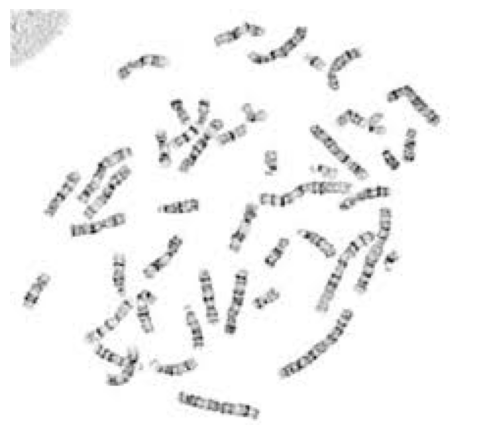

In [7]:
print(image.shape)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off') 
plt.show()

## Cortes de máscara da imagem

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


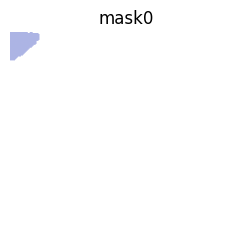

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


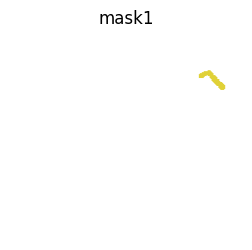

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


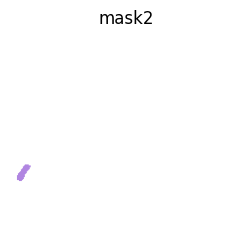

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


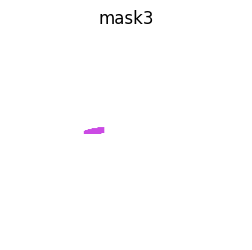

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


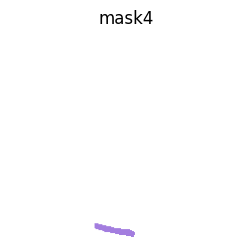

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


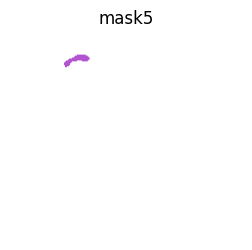

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


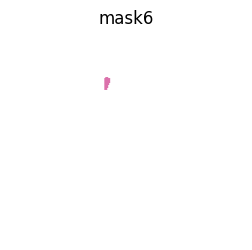

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


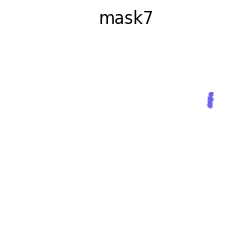

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


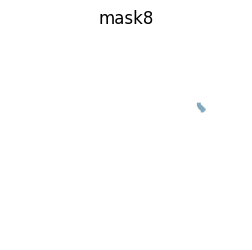

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


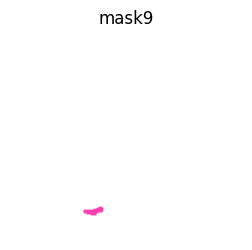

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


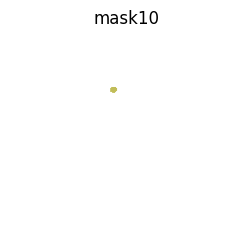

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


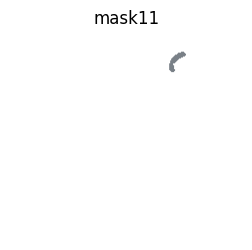

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


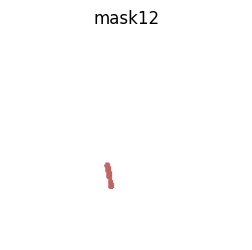

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


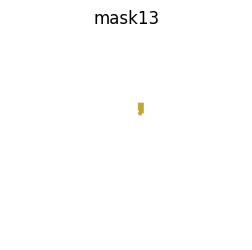

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


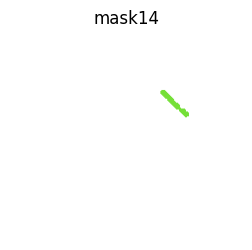

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


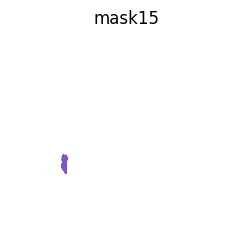

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


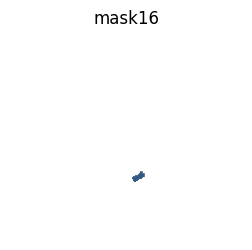

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


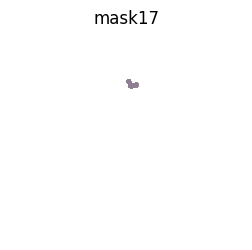

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


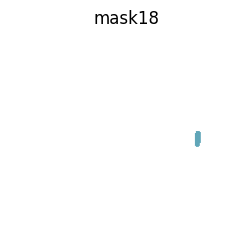

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


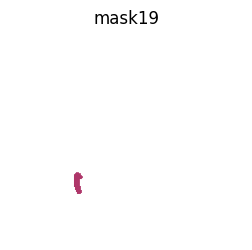

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


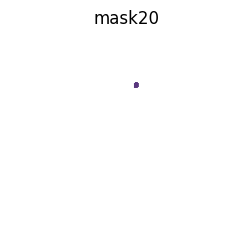

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


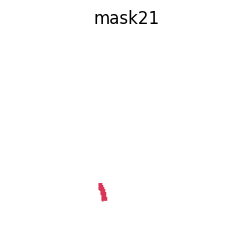

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


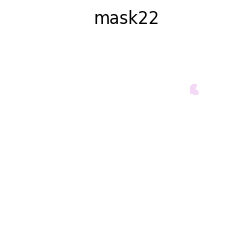

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


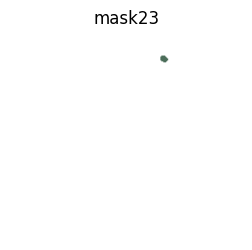

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


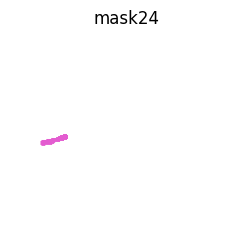

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


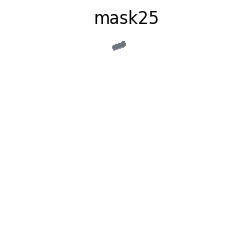

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


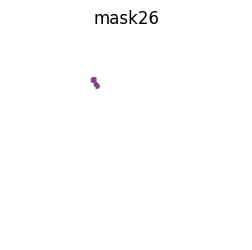

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


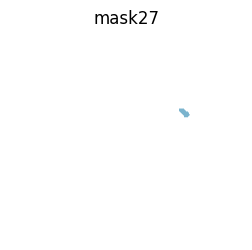

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


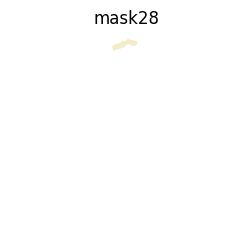

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


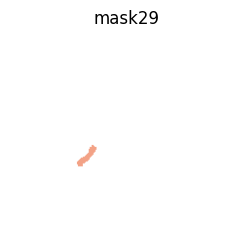

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


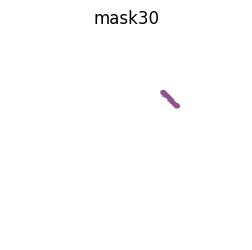

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


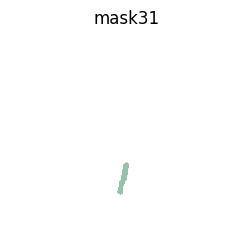

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


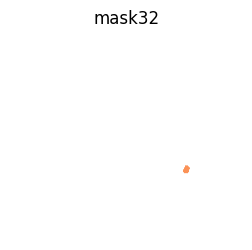

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


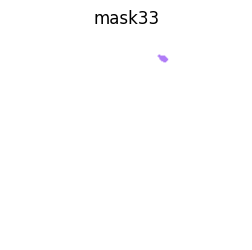

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


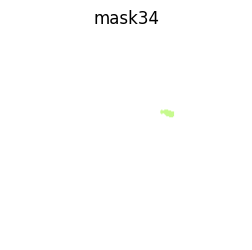

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


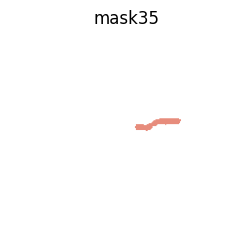

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


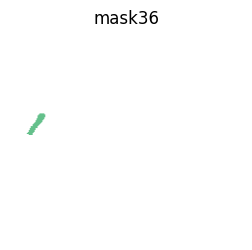

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


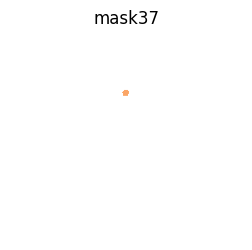

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


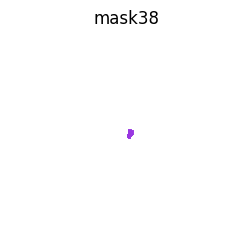

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


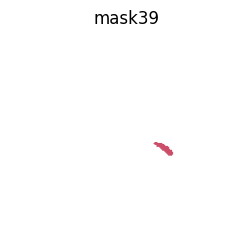

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


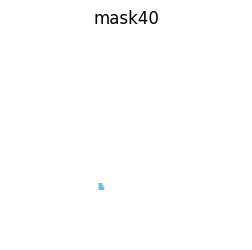

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


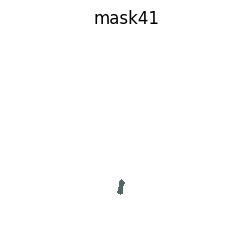

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


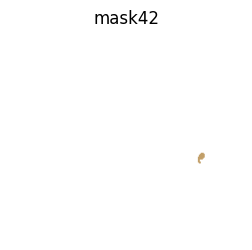

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


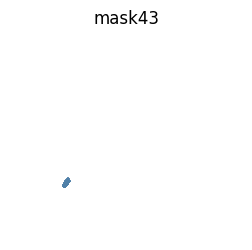

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


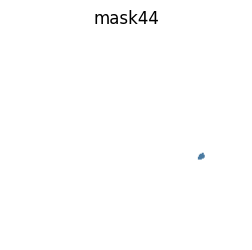

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


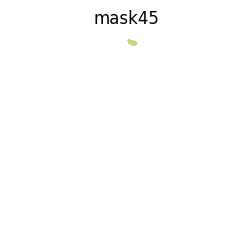

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


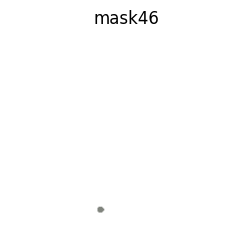

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


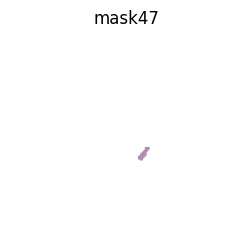

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


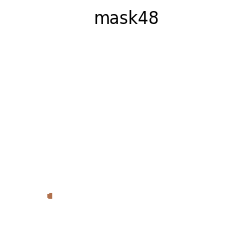

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


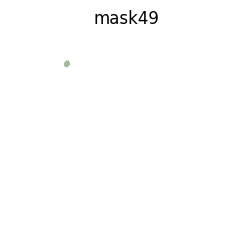

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


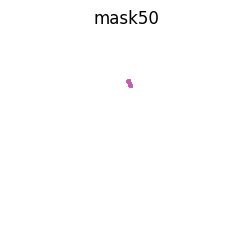

In [8]:
'''
    Abaixo, irei percorrer todas as máscaras geradas pelo algoritmo (acima), e depois, farei o "plotting" de cada uma das máscaras (POTENCIAIS CROMOSSOMOS)

    Como podemos ver no output, o algorítmo encontrou potenciais 50 CROMOSSOMOS (Um número muito próximo do real [46]).

    Este valor se deve principalmente a imagem de baixa qualidade que usamos, através de uma análise das imagens abaixo (output),
    poderemos ver que o modelo está encontrando diversos "falsos cromossomos" em apenas 1 cromossomo.
'''

for i in range(len(masks1)):
    plt.figure(figsize=(3,3))
    plt.imshow(bgw)
    show_anns([masks1[i]])
    plt.title(f'mask{i}')
    plt.axis('off')  
    plt.show()

# Extração de retângulo da máscara

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask0 bbox: [0, 29, 0, 28]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\000.png


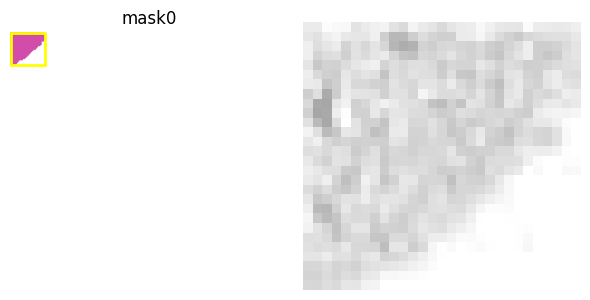

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask1 bbox: [192, 218, 39, 58]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\001.png


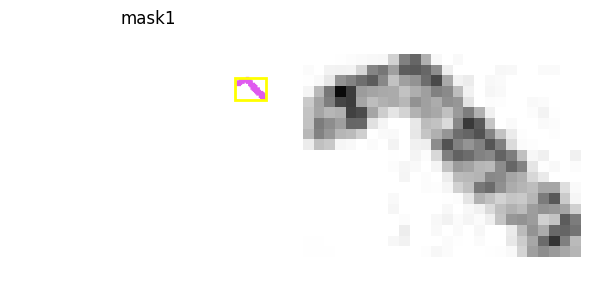

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask2 bbox: [7, 20, 135, 151]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\002.png


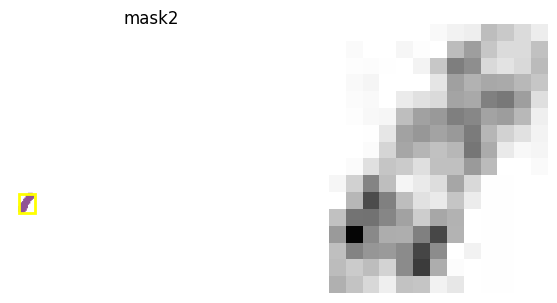

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask3 bbox: [75, 95, 97, 103]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\003.png


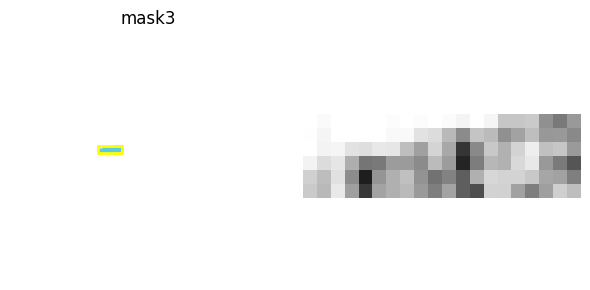

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask4 bbox: [86, 126, 195, 208]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\004.png


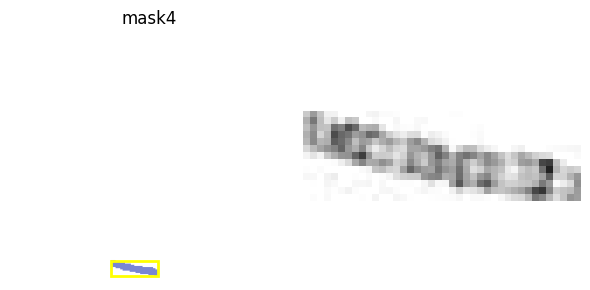

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask5 bbox: [55, 80, 23, 35]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\005.png


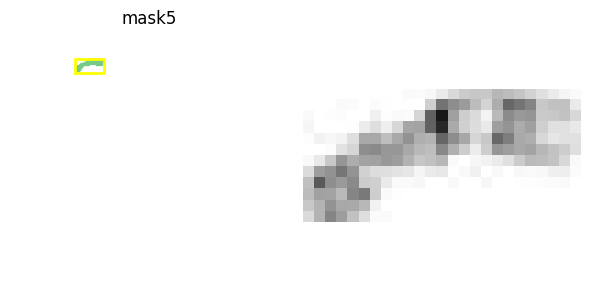

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask6 bbox: [96, 101, 46, 58]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\006.png


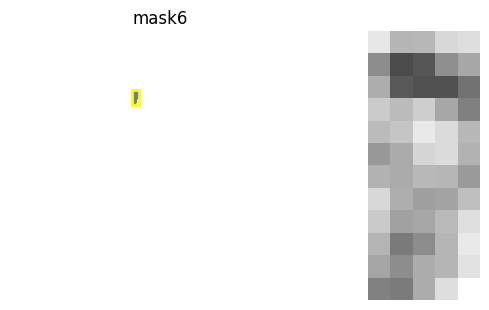

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask7 bbox: [200, 206, 61, 77]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\007.png


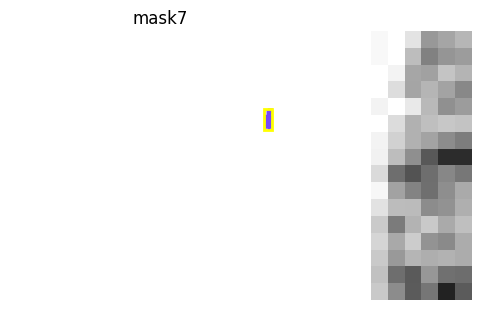

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask8 bbox: [190, 198, 72, 81]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\008.png


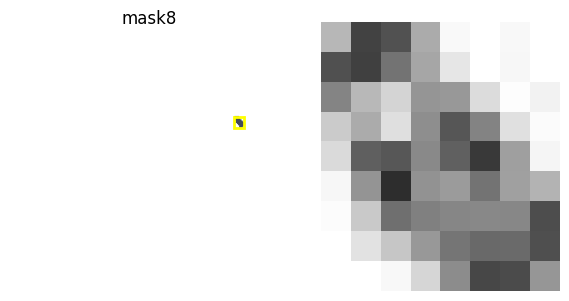

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask9 bbox: [74, 94, 178, 186]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\009.png


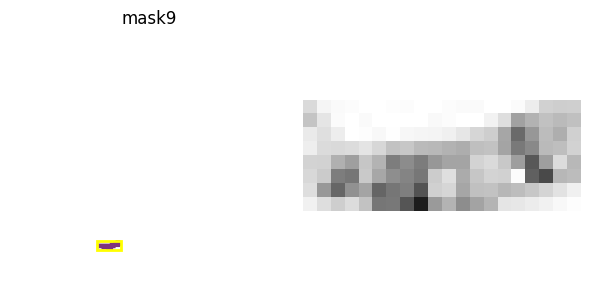

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask10 bbox: [102, 108, 56, 61]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\010.png


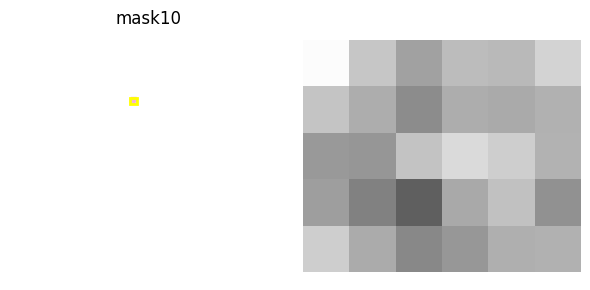

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask11 bbox: [162, 178, 20, 40]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\011.png


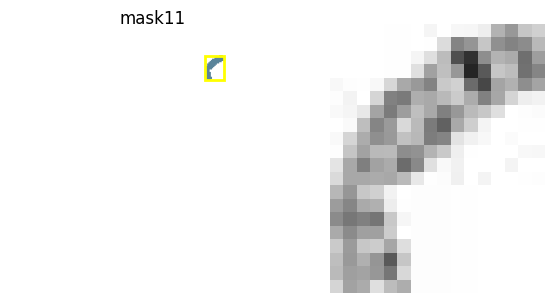

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask12 bbox: [96, 105, 133, 159]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\012.png


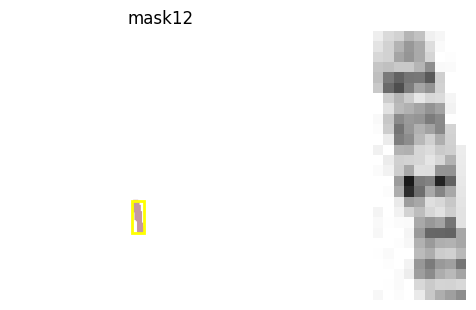

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask13 bbox: [130, 135, 72, 84]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\013.png


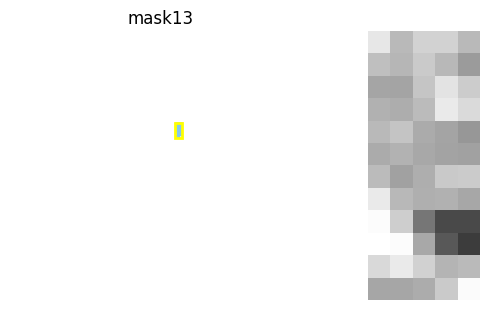

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask14 bbox: [153, 181, 59, 86]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\014.png


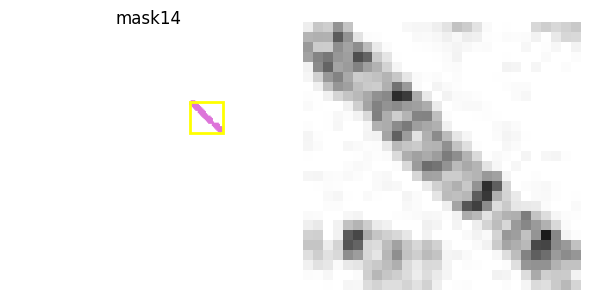

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask15 bbox: [52, 58, 124, 144]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\015.png


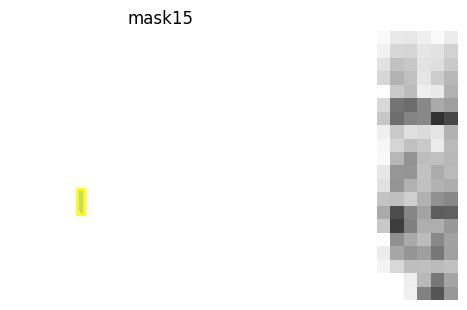

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask16 bbox: [124, 136, 142, 152]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\016.png


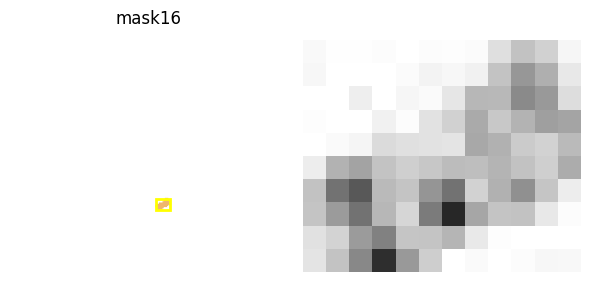

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask17 bbox: [118, 130, 48, 57]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\017.png


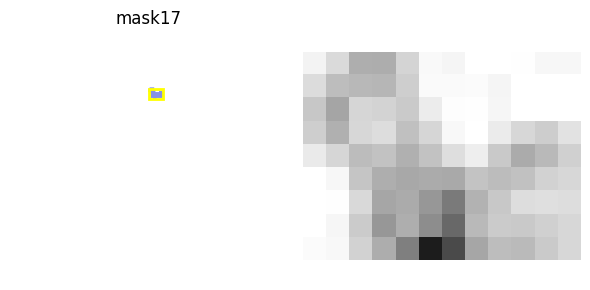

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask18 bbox: [188, 193, 101, 116]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\018.png


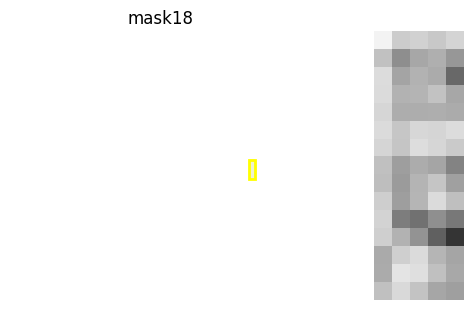

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask19 bbox: [65, 73, 143, 164]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\019.png


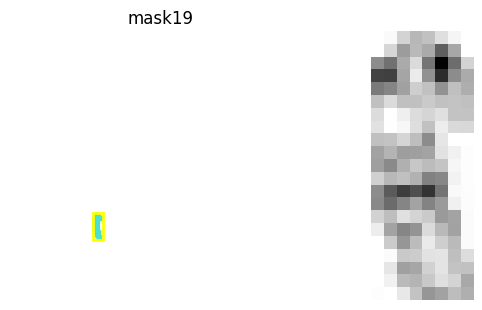

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask20 bbox: [126, 130, 51, 56]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\020.png


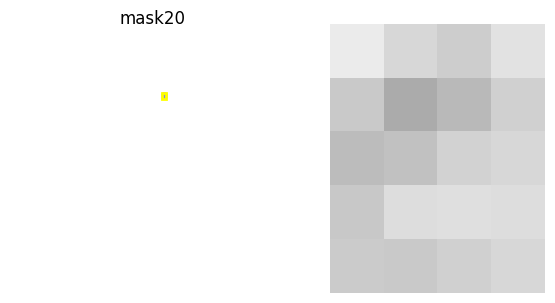

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask21 bbox: [90, 98, 154, 172]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\021.png


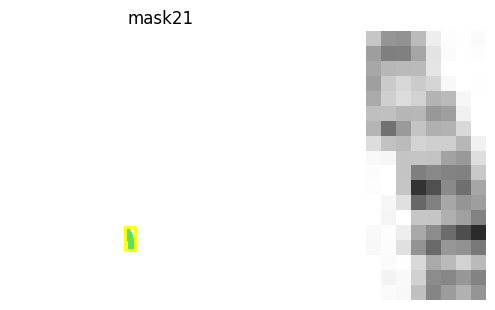

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask22 bbox: [183, 191, 53, 63]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\022.png


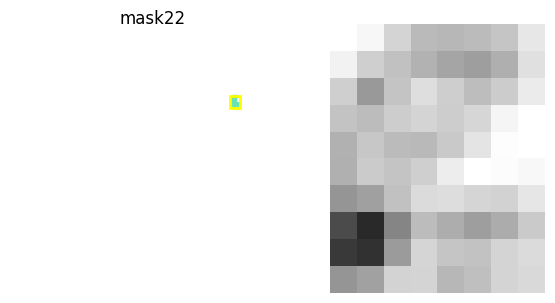

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask23 bbox: [153, 160, 24, 30]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\023.png


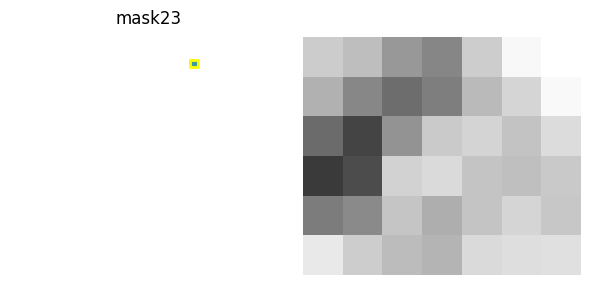

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask24 bbox: [31, 58, 104, 115]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\024.png


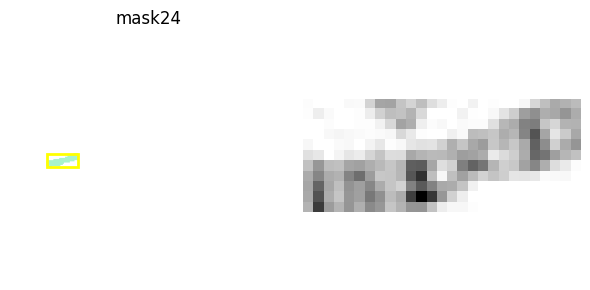

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask25 bbox: [104, 117, 9, 18]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\025.png


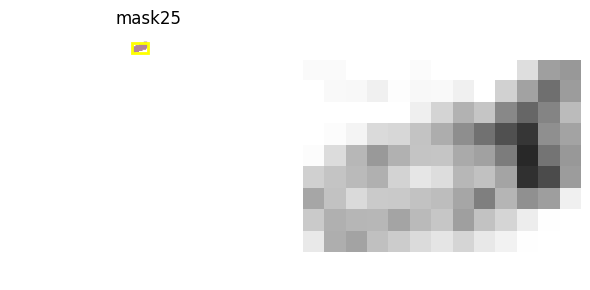

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask26 bbox: [82, 91, 46, 57]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\026.png


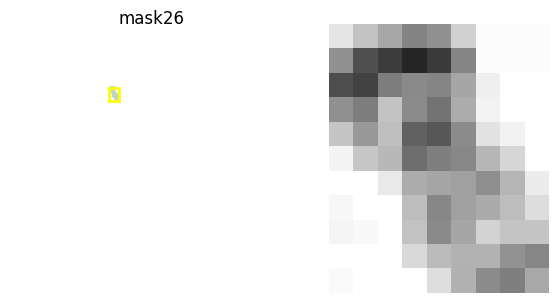

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask27 bbox: [172, 182, 78, 86]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\027.png


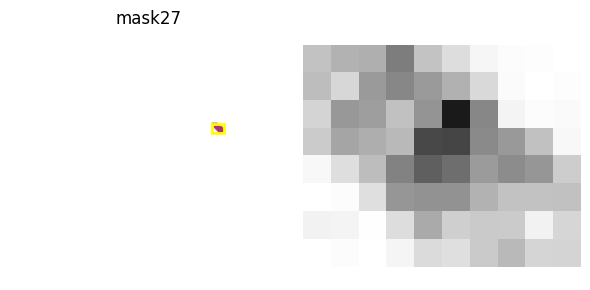

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask28 bbox: [104, 129, 7, 18]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\028.png


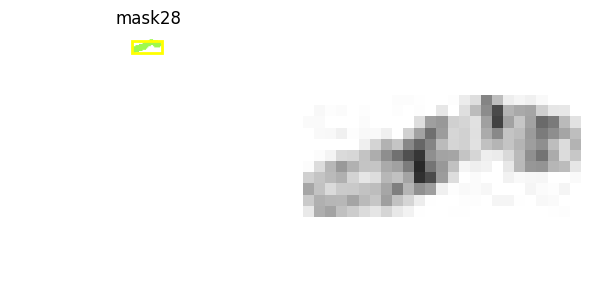

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask29 bbox: [68, 87, 115, 136]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\029.png


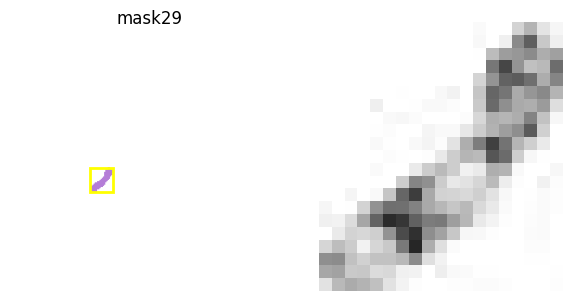

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask30 bbox: [153, 172, 59, 77]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\030.png


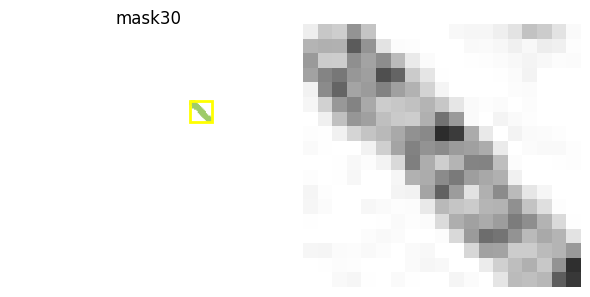

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask31 bbox: [109, 120, 133, 165]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\031.png


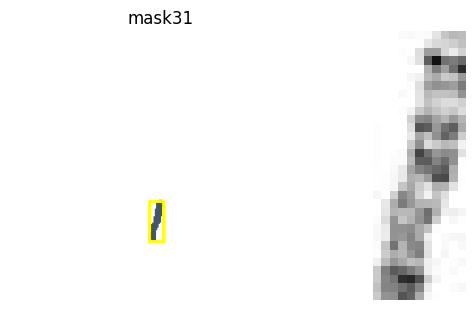

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask32 bbox: [176, 182, 136, 143]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\032.png


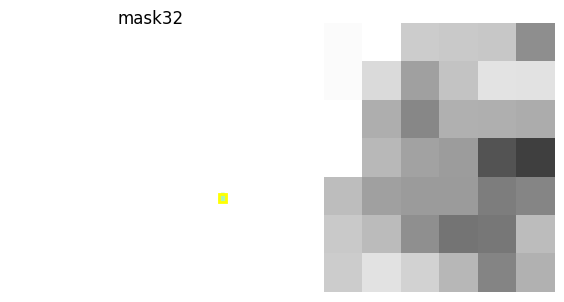

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask33 bbox: [150, 160, 23, 30]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\033.png


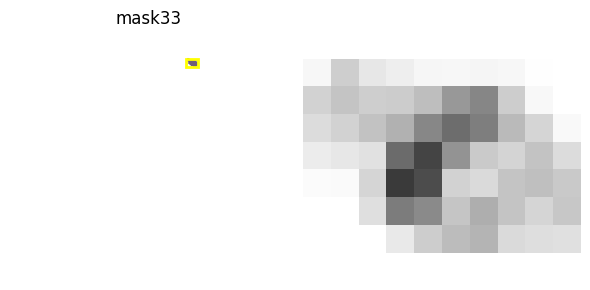

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask34 bbox: [153, 166, 79, 86]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\034.png


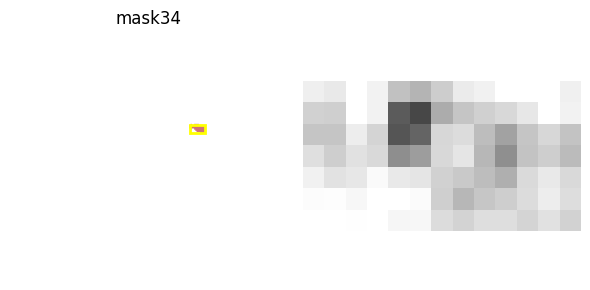

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask35 bbox: [127, 173, 88, 100]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\035.png


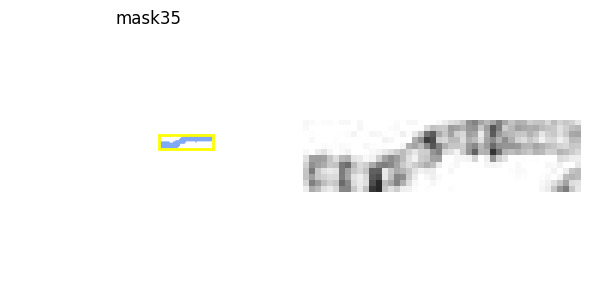

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask36 bbox: [17, 35, 83, 104]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\036.png


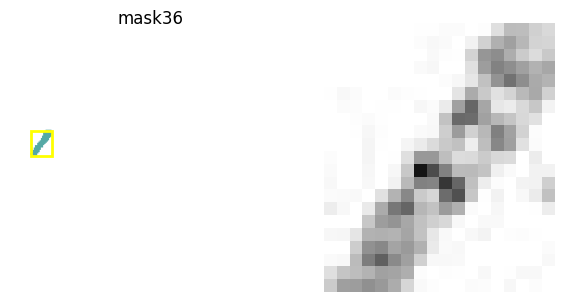

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask37 bbox: [114, 120, 59, 64]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\037.png


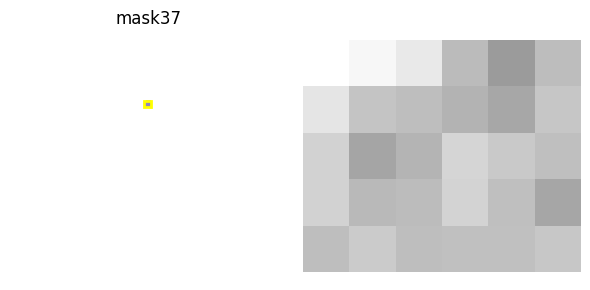

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask38 bbox: [119, 125, 99, 108]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\038.png


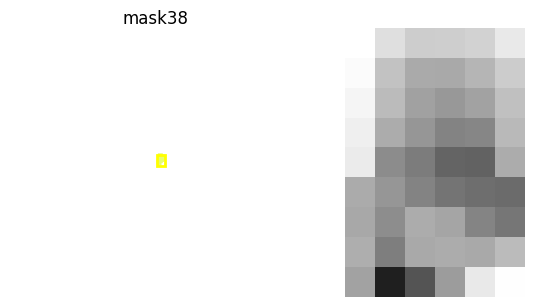

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask39 bbox: [146, 165, 112, 125]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\039.png


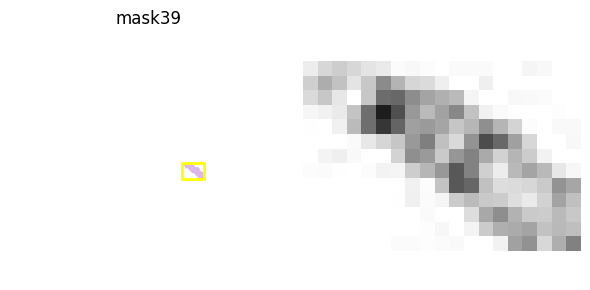

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask40 bbox: [90, 95, 154, 160]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\040.png


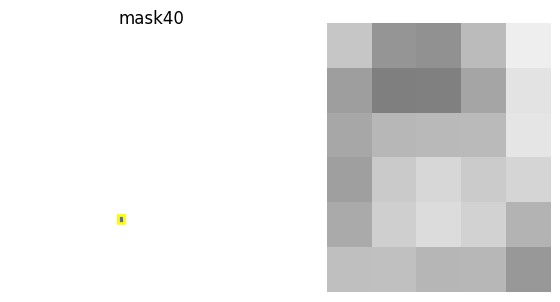

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask41 bbox: [109, 116, 150, 165]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\041.png


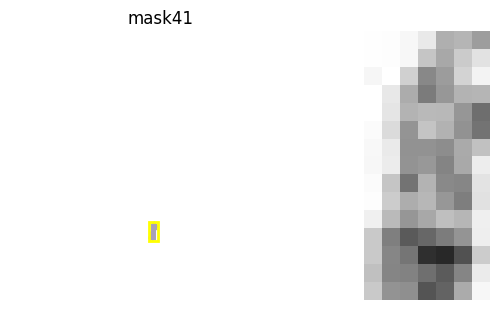

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask42 bbox: [191, 197, 123, 133]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\042.png


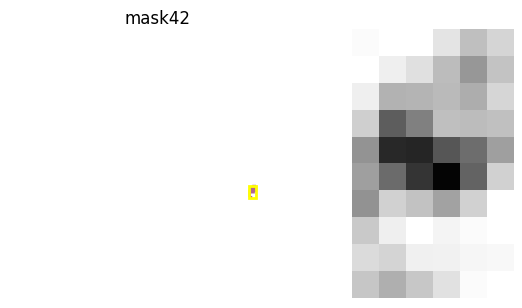

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask43 bbox: [53, 61, 148, 158]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\043.png


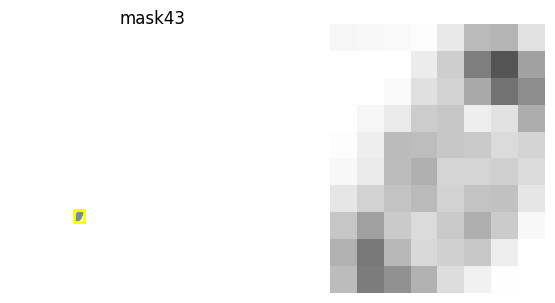

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask44 bbox: [191, 197, 123, 129]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\044.png


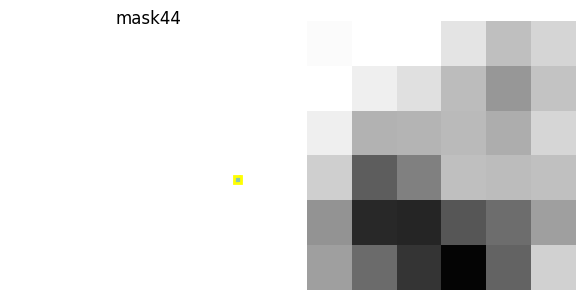

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask45 bbox: [119, 129, 7, 13]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\045.png


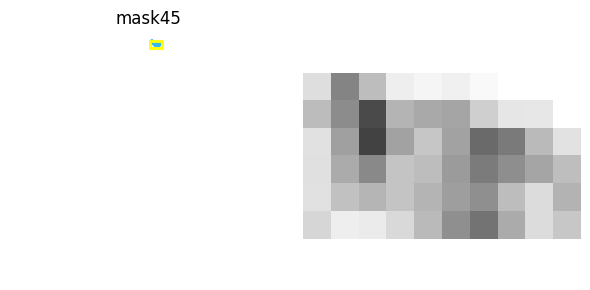

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask46 bbox: [89, 95, 178, 183]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\046.png


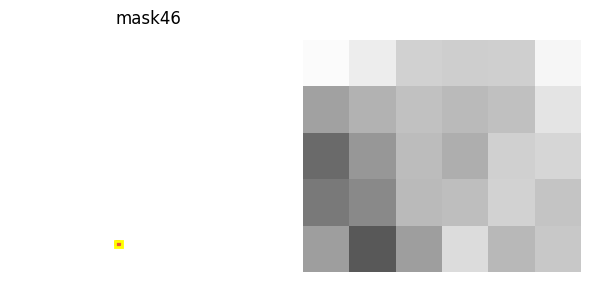

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask47 bbox: [130, 141, 117, 130]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\047.png


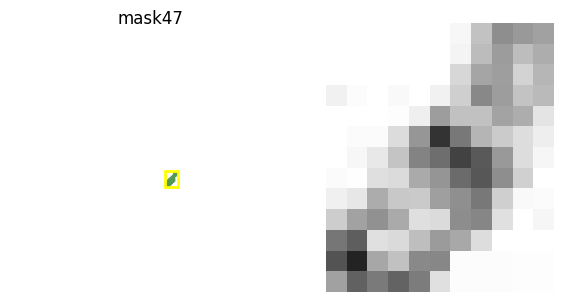

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask48 bbox: [38, 42, 164, 169]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\048.png


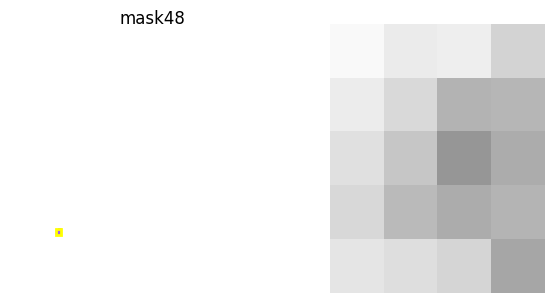

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask49 bbox: [55, 60, 29, 35]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\049.png


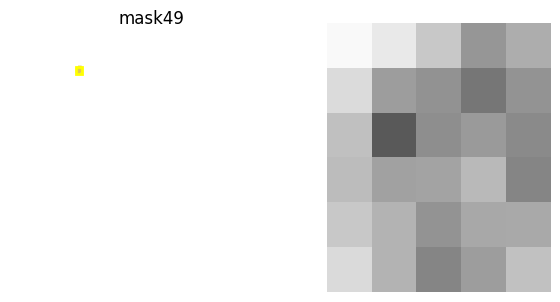

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [255.0..255.0].


mask50 bbox: [118, 124, 48, 56]
Imagem salva em em: d:\Github\Karyotype_recognition\SAM2_demos\recortes\ITChromo-Leo\050.png


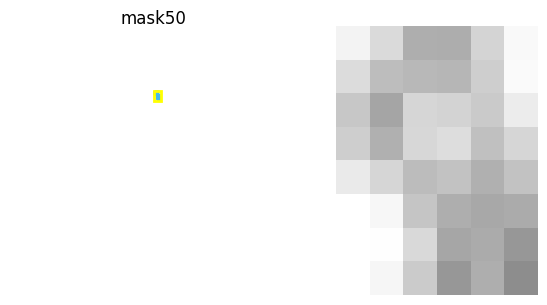

In [9]:
'''
    Com as máscaras obtidas anteriormente, é possível plottarmos retângulos de identificação em cada cromossomo identificado pelo modelo.
    Após realizarmos os "recortes", as imagens serão salvas na pasta "/recortes/"
    Como podemos ver a seguir:
'''

# Criação da pasta recortes
os.makedirs('recortes/ITChromo-Leo', exist_ok=True)

# Itera pelas máscaras
for i in range(len(masks1)):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    ax[0].imshow(bgw)
    masksi = masks1[i]
    xc, yc, w, h = masksi['bbox']
    x0, y0, x1, y1 = int(xc), int(yc), int(xc + w), int(yc + h)

    print(f'mask{i} bbox: {[x0, x1, y0, y1]}')

    # Recorte da imagem original
    boximage = image[y0:y1, x0:x1, :]

    # Caminho absoluto para salvar
    save_path = os.path.abspath(os.path.join('recortes/ITChromo-Leo', f'{str(i).zfill(3)}.png'))
    print(f"Imagem salva em em: {save_path}")

    # Salva o recorte
    cv2.imwrite(save_path, cv2.cvtColor(boximage, cv2.COLOR_RGB2BGR))

    # Exibição
    rect = patches.Rectangle((xc, yc), w, h, linewidth=2, edgecolor='yellow', fill=False)
    show_anns([masksi], ax[0])
    ax[0].add_patch(rect)
    ax[1].imshow(boximage)
    ax[0].set_title(f'mask{i}')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()


mask0 bbox: [0, 29, 0, 28]
mask1 bbox: [192, 218, 39, 58]
mask2 bbox: [7, 20, 135, 151]
mask3 bbox: [75, 95, 97, 103]
mask4 bbox: [86, 126, 195, 208]
mask5 bbox: [55, 80, 23, 35]
mask6 bbox: [96, 101, 46, 58]
mask7 bbox: [200, 206, 61, 77]
mask8 bbox: [190, 198, 72, 81]
mask9 bbox: [74, 94, 178, 186]
mask10 bbox: [102, 108, 56, 61]
mask11 bbox: [162, 178, 20, 40]
mask12 bbox: [96, 105, 133, 159]
mask13 bbox: [130, 135, 72, 84]
mask14 bbox: [153, 181, 59, 86]
mask15 bbox: [52, 58, 124, 144]
mask16 bbox: [124, 136, 142, 152]
mask17 bbox: [118, 130, 48, 57]
mask18 bbox: [188, 193, 101, 116]
mask19 bbox: [65, 73, 143, 164]
mask20 bbox: [126, 130, 51, 56]
mask21 bbox: [90, 98, 154, 172]
mask22 bbox: [183, 191, 53, 63]
mask23 bbox: [153, 160, 24, 30]
mask24 bbox: [31, 58, 104, 115]
mask25 bbox: [104, 117, 9, 18]
mask26 bbox: [82, 91, 46, 57]
mask27 bbox: [172, 182, 78, 86]
mask28 bbox: [104, 129, 7, 18]
mask29 bbox: [68, 87, 115, 136]
mask30 bbox: [153, 172, 59, 77]
mask31 bbox: [109, 120, 1

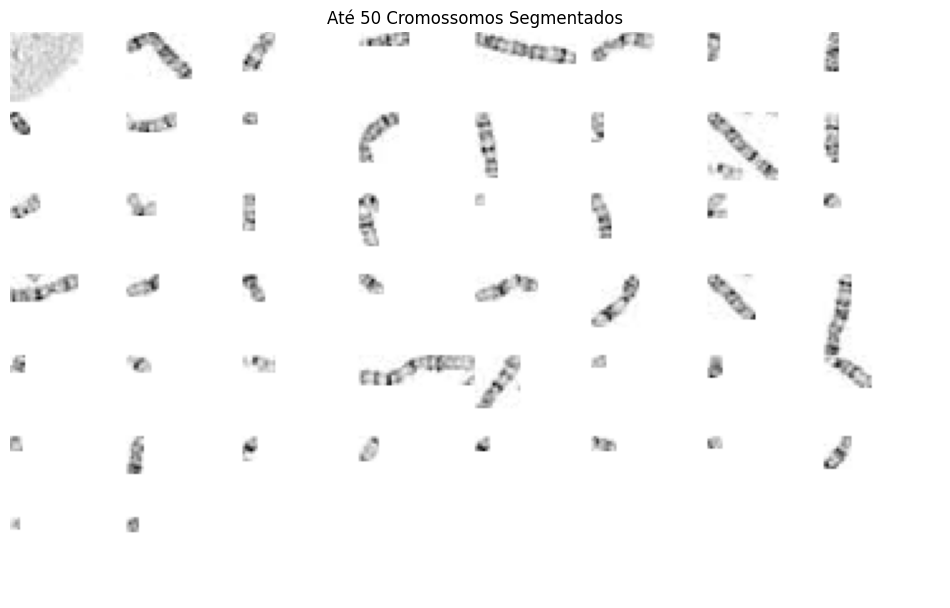

✅ Imagem única salva em: recortes/ITChromo-Leo/final_image-LEO.png


In [13]:
import math

# Lista para guardar os recortes
recortes = []

# Itera pelas máscaras para fazer os recortes
for i in range(len(masks1)):
    masksi = masks1[i]
    xc, yc, w, h = masksi['bbox']
    x0, y0, x1, y1 = int(xc), int(yc), int(xc + w), int(yc + h)

    print(f'mask{i} bbox: {[x0, x1, y0, y1]}')

    # Recorte da imagem original
    boximage = image[y0:y1, x0:x1, :]
    recortes.append(boximage)  # Adiciona o recorte à lista

# Limitar para no máximo 50 recortes
MAX_RECORTE = 50
recortes = recortes[:MAX_RECORTE]
print(f"➡️  Total de recortes usados: {len(recortes)}")

# Definindo o layout da imagem final (ex: 6 linhas x 8 colunas, dependendo da quantidade)
num_recortes = len(recortes)
cols = math.ceil(math.sqrt(num_recortes))     # Número de colunas
rows = math.ceil(num_recortes / cols)          # Número de linhas

# Tamanho máximo de cada recorte para padronizar (pega o maior w,h encontrado)
max_height = max(r.shape[0] for r in recortes)
max_width = max(r.shape[1] for r in recortes)

# Cria imagem final em branco (fundo branco)
final_image = np.ones((rows * max_height, cols * max_width, 3), dtype=np.uint8) * 255

# Coloca os recortes na imagem final
for idx, recorte in enumerate(recortes):
    row = idx // cols
    col = idx % cols
    y_offset = row * max_height
    x_offset = col * max_width

    h, w = recorte.shape[:2]
    final_image[y_offset:y_offset+h, x_offset:x_offset+w, :] = recorte

# Mostrar a imagem final
plt.figure(figsize=(12, 12))
plt.imshow(final_image)
plt.axis('off')
plt.title(f"Até {MAX_RECORTE} Cromossomos Segmentados")
plt.show()

# Opcional: salvar a imagem final em disco
cv2.imwrite('recortes/ITChromo-Leo/final_image-LEO.png', cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
print("✅ Imagem única salva em: recortes/ITChromo-Leo/final_image-LEO.png")


In [11]:
'''
    Conclui-se que, utilizando o modelo "vit-b" (Vision Transformer BASE), conseguimos obter resultados melhores e mais acertivos.
    Também observa-se um tempo de resposta MUITO MENOR.

    Antes -> Identificação de 79 cromossomos em aprox. 4 minutos            (tempo de identificação + plottagem gráfica)
    Depois -> Identificação de 50 cromossomos em aprox. 47 segundos.        (tempo de identificação + plottagem gráfica)
'''

'\n    Conclui-se que, utilizando o modelo "vit-b" (Vision Transformer BASE), conseguimos obter resultados melhores e mais acertivos.\n    Também observa-se um tempo de resposta MUITO MENOR.\n\n    Antes -> Identificação de 79 cromossomos em aprox. 4 minutos            (tempo de identificação + plottagem gráfica)\n    Depois -> Identificação de 50 cromossomos em aprox. 47 segundos.        (tempo de identificação + plottagem gráfica)\n'